In [1]:
%pip install haystack-ai trafilatura datasets txtai pandas datasets matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = api_key  

## dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("rajpurkar/squad_v2")

c:\Users\nessa\OneDrive\Desktop\coding\machineLearning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [4]:
import pandas as pd

data_union = pd.concat([pd.DataFrame(dataset['train']), pd.DataFrame(dataset['validation'])], axis=0)

## separação de informações

o dataset tem esse formato
- Index(['id', 'title', 'context', 'question', 'answers'], dtype='object')

#### Contexto
existem dois tipos de separação para contexto
- mantendo todas as tuplas separadamente, ou seja, title e seu context correspondente
- unindo todos os context de um mesmo title, reduzindo bastante o numero de tuplas e deixando os contextos mais completos

#### Perguntas e Resposta (Q&A)
- obtendo o titulo, pergunta e resposta de cada tupla e salvando individualmente

In [5]:
from enum import Enum

class Contexto(Enum):
    GERAIS_100 = 'contexto_gerais_100'
    GERAIS_50 = 'contexto_gerais_50'
    GERAIS_25 = 'contexto_gerais_25'
    GERAIS_15 = 'contexto_gerais_15'
    PORTITULO_100 = 'contexto_portitulo_100'
    PORTITULO_50 = 'contexto_portitulo_50'
    PORTITULO_25 = 'contexto_portitulo_25'
    PORTITULO_15 = 'contexto_portitulo_15'
    QA_PAIRS = 'qa_pairs'
    QA_PAIRS_PORTITULO_100 = 'qa_pairs_portitulo_100'
    QA_PAIRS_PORTITULO_50 = 'qa_pairs_portitulo_50'
    QA_PAIRS_PORTITULO_25 = 'qa_pairs_portitulo_25'
    QA_PAIRS_PORTITULO_15 = 'qa_pairs_portitulo'
    QA_PAIRS_GERAIS_100 = 'qa_pairs_gerais_100'
    QA_PAIRS_GERAIS_50 = 'qa_pairs_gerais_50'
    QA_PAIRS_GERAIS_25 = 'qa_pairs_gerais_25'
    QA_PAIRS_GERAIS_15 = 'qa_pairs_gerais_15'
    TESTE_PORTITULO = 'contexto_portitulo_teste'
    TESTE_GERAIS = 'contexto_gerais_teste'
    QA_TESTE_PORTITULO = 'qa_teste_portitulo'
    QA_TESTE_GERAIS = 'qa_teste_gerais'

### unindo contextos por titulo

In [ ]:
def consolidate_contexts(group):
    # Remover duplicatas dentro de um mesmo título
    unique_contexts = set(group)
    # Juntar os contextos em um único texto corrido
    return " ".join(unique_contexts)

contextos_df_unindo = data_union.copy().groupby("title")["context"].apply(consolidate_contexts).reset_index()
contextos_df_unindo.rename(columns={"context": "contextos"}, inplace=True)

In [ ]:
# 100% dos dados (embaralhados)
contextos_df_unindo.to_csv(f'''data/{Contexto.GERAIS_100.value}.csv''', index=False)

# 50% dos dados
contextos_df_unindo.sample(frac=0.5, random_state=42).to_csv(f'''data/{Contexto.GERAIS_50.value}.csv''', index=False)

# 25% dos dados
contextos_df_unindo.sample(frac=0.25, random_state=42).to_csv(f'''data/{Contexto.GERAIS_25.value}.csv''', index=False)

# 15% dos dados
contextos_df_unindo.sample(frac=0.15, random_state=42).to_csv(f'''data/{Contexto.GERAIS_15.value}.csv''', index=False)

print("Arquivos gerados com sucesso!")

### sem unir por titulo

In [ ]:
contextos_df_title = data_union.copy()
contextos_df_title = contextos_df_title[["title", "context"]]

# Embaralha os dados antes de amostrar
contextos_df_title = contextos_df_title.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# 100% dos dados
contextos_df_title.to_csv(f'''data/{Contexto.PORTITULO_100.value}.csv''', index=False)

# 50% dos dados
contextos_df_title.sample(frac=0.5, random_state=42).to_csv(f'''data/{Contexto.PORTITULO_50.value}.csv''', index=False)

# 25% dos dados
contextos_df_title.sample(frac=0.25, random_state=42).to_csv(f'''data/{Contexto.PORTITULO_25.value}.csv''', index=False)

# 15% dos dados
contextos_df_title.sample(frac=0.15, random_state=42).to_csv(f'''data/{Contexto.PORTITULO_15.value}.csv''', index=False)

print("Arquivos gerados com sucesso!")

Arquivos gerados com sucesso!


### separando qa

In [95]:
qa_df = data_union[["title", "question", "answers"]]

def extract_answers(row):
    return row['answers']['text']

qa_df['answers'] = qa_df.apply(extract_answers, axis=1)
qa_df = qa_df[qa_df['answers'].str.len() > 0]

def process_answers(answer_list):
    if not isinstance(answer_list, list):
        return answer_list  # Retorna diretamente caso não seja uma lista
    
    unique_answers = list(set(answer_list))  # Remove duplicatas
    
    if len(unique_answers) == 1:
        return unique_answers[0]  # Retorna como string se houver apenas um item único
    
    return unique_answers  # Retorna a lista se houver múltiplos valores distintos

qa_df['answers'] = qa_df['answers'].apply(process_answers)

qa_df.to_csv(f'''data/qa/{Contexto.QA_PAIRS.value}_geral.csv''', index=False)

/var/folders/m5/gxpxpsfx2y5g_0qfn36b5jcw0000gn/T/ipykernel_81362/590395369.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_df['answers'] = qa_df.apply(extract_answers, axis=1)


## haystack

- inicializando itens do haystack

In [8]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.components.converters import TextFileToDocument
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.embedders import OpenAIDocumentEmbedder, OpenAITextEmbedder
from haystack.components.writers import DocumentWriter
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
import time

- montando pipeline de indexacao de documentos
- montando pipeline de recuperação e geração

In [9]:
def pipeline(source_file: str, qa_passado_df: pd.DataFrame, output_filename: str):
    text_file_converter = TextFileToDocument()
    cleaner = DocumentCleaner()
    splitter = DocumentSplitter()
    embedder = OpenAIDocumentEmbedder()
    indexing_pipeline = Pipeline()

    text_embedder = OpenAITextEmbedder()
    template = """Given these contexts, answer the question.
                    Context:
                    {% for doc in documents %}
                        {{ doc.content }}
                    {% endfor %}
                    Question: {{query}}
                    Answer:"""
    prompt_builder = PromptBuilder(template=template)
    llm = OpenAIGenerator()
    rag_pipeline = Pipeline()

    print('------------------- montando pipeline de indexação de docs')
    document_store = InMemoryDocumentStore()
    writer = DocumentWriter(document_store)
    retriever = InMemoryEmbeddingRetriever(document_store)
    
    indexing_pipeline.add_component("converter", text_file_converter)
    indexing_pipeline.add_component("cleaner", cleaner)
    indexing_pipeline.add_component("splitter", splitter)
    indexing_pipeline.add_component("embedder", embedder)
    indexing_pipeline.add_component("writer", writer)

    indexing_pipeline.connect("converter.documents", "cleaner.documents")
    indexing_pipeline.connect("cleaner.documents", "splitter.documents")
    indexing_pipeline.connect("splitter.documents", "embedder.documents")
    indexing_pipeline.connect("embedder.documents", "writer.documents")

    print('------------------- pipeline montada, lendo arquivo')
    indexing_pipeline.run(data={"sources": [f'''data/{source_file}.csv''']})

    print(f"Documentos do arquivo {source_file} indexados com sucesso!")
    print('------------------- montando pipelines de rag (retriver e generator)')

    rag_pipeline.add_component("text_embedder", text_embedder)
    rag_pipeline.add_component("retriever", retriever)
    rag_pipeline.add_component("prompt_builder", prompt_builder)
    rag_pipeline.add_component("llm", llm)

    rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
    rag_pipeline.connect("retriever.documents", "prompt_builder.documents")
    rag_pipeline.connect("prompt_builder", "llm")

    print('------------------- pipelines de rag montada')

    print('------------------- iniciando testes de perguntas e respostas')

    results = []
    i = 0
    total = len(qa_passado_df)
    
    for index, row in qa_passado_df.iterrows():
        query = row["question"]
        expected_answer = row["answers"]
        
        generated_answer = rag_pipeline.run(data={"prompt_builder": {"query": query}, "text_embedder": {"text": query}})

        results.append({
            "title": row["title"],
            "question": query,
            "expected_answer": expected_answer,
            "generated_answer": generated_answer["llm"]["replies"],
        })
        i += 1

        print(f"################### Processando ({i}/{total})...")
        time.sleep(0.1)
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'''data/qa/{output_filename}.csv''', index=False)

    print(f"\n-------------------Finalizado! Resultados salvos em {output_filename}")


## resultados haystack por titulo

In [ ]:
qa_df_5_porcento = qa_df.sample(frac=0.05, random_state=42)
qa_df_01_porcento = qa_df.sample(frac=0.001, random_state=42)

In [ ]:
qa_df_5_porcento.head()

In [ ]:
qa_df_usado = qa_df_5_porcento

In [ ]:
pipeline(Contexto.PORTITULO_15.value, qa_df_usado, Contexto.QA_PAIRS_PORTITULO_15.value)

In [ ]:
pipeline(Contexto.PORTITULO_25.value, qa_df_usado, Contexto.QA_PAIRS_PORTITULO_25.value)

In [ ]:
pipeline(Contexto.PORTITULO_50.value, qa_df_usado, Contexto.QA_PAIRS_PORTITULO_50.value)

In [ ]:
pipeline(Contexto.PORTITULO_100.value, qa_df_usado, Contexto.QA_PAIRS_PORTITULO_100.value)

## resultados haystack geral

In [ ]:
pipeline(Contexto.GERAIS_15.value, qa_df_usado, Contexto.QA_PAIRS_GERAIS_15.value)

In [ ]:
pipeline(Contexto.GERAIS_25.value, qa_df_usado, Contexto.QA_PAIRS_GERAIS_25.value)

In [ ]:
pipeline(Contexto.GERAIS_50.value, qa_df_usado, Contexto.QA_PAIRS_GERAIS_50.value)

In [ ]:
pipeline(Contexto.GERAIS_100.value, qa_df_usado, Contexto.QA_PAIRS_GERAIS_100.value)

## comparação de respostas com llm

In [62]:
from openai import OpenAI

def use_llm(test, real):
    cliente = OpenAI(api_key=api_key)

    prompt = f'''
        Você é um assistente que compara textos. 
        Compare a resposta esperada '{test}' com a resposta adquirida '{real}' e diga se são semanticamente semelhantes. 

        Responda em uma escala de 0 a 10, onde 0 significa que os textos são completamente diferentes e 10 significa que são idênticos.

        Tente entender o sentido completo da resposta, não apenas palavras-chave.
        Mas também se atente a detalhes como palavras-chave e seus significados.
        Por exemplo, orações com palavras diferentes mas com o mesmo significado devem ser consideradas semelhantes.
        Palavras com sentidos opostos sem nenhuma negação devem ser consideradas diferentes.
        Pode ser que a resposta adquirida seja mais completa que a esperada, mas ainda assim seja considerada semelhante.
        Caso tenha uma negação durante a frase, observe o sentido geral da frase, verificando se a negação do oposto talvez seja semelhante a confirmação da outra frase.

        Responda apenas o número equivalente à semelhança dos textos.

        # exemplo de saida
        10
    '''

    messages = [
        {
            "role": "user",
            "content": prompt
        },
    ]

    response = cliente.chat.completions.create(
        model="gpt-4o",
        store=True,
        messages=messages,
        temperature=0
    )
    return response.choices[0].message.content


def is_similar_using_llm(
    test: str = "",
    real: str = ""):
    
    response = use_llm(test, real)
    return response


In [71]:
teste = is_similar_using_llm("Eu não sou homossexual", "Eu sou heterossexual")
teste2 = is_similar_using_llm('Central Standard Time',"['The contexts provided do not mention Saskatoon or its time observance specific to time zones, Daylight Saving Time, or any other relevant information. Therefore, based on the information given, I cannot determine what time Saskatoon observes all year long.']")
teste3 = is_similar_using_llm('VHF omnidirectional range',['VOR stands for VHF Omnidirectional Range.'])
teste4 = is_similar_using_llm('32nd',"['In 2009, Tucson ranked as the 32nd largest city in the United States.']")
print(f"Teste 1: {teste}, Teste 2: {teste2}, Teste 3: {teste3}, Teste 4: {teste4}")

Teste 1: 8, Teste 2: 0, Teste 3: 9, Teste 4: 7


In [23]:
def compare_respostas_usando_llm(arquivo_csv: str):
    df = pd.read_csv(f'''data/qa/{arquivo_csv}.csv''')
    df['is_similar'] = df.apply(lambda row: is_similar_using_llm(row['expected_answer'], row['generated_answer']), axis=1)
    df.to_csv(f'''data/qa/{arquivo_csv}.csv''', index=False)

def compare_respostas_usando_llm_contagem(arquivo_csv: str):
    df = pd.read_csv(f'''data/qa/{arquivo_csv}.csv''')

    count = 0
    total = len(df)

    for index, row in df.iterrows():
        df.loc[index, 'is_similar'] = is_similar_using_llm(row['expected_answer'], row['generated_answer'])
        
        count += 1
        
        print(f'*********** Progresso: {count}/{total}')

    df.to_csv(f'''data/qa/{arquivo_csv}.csv''', index=False)

In [ ]:
compare_respostas_usando_llm_contagem(Contexto.QA_PAIRS_GERAIS_15.value)

In [ ]:
compare_respostas_usando_llm_contagem(Contexto.QA_PAIRS_GERAIS_25.value)

In [ ]:
compare_respostas_usando_llm_contagem(Contexto.QA_PAIRS_GERAIS_50.value)

In [ ]:
compare_respostas_usando_llm_contagem(Contexto.QA_PAIRS_GERAIS_100.value)

In [ ]:
compare_respostas_usando_llm_contagem(Contexto.QA_PAIRS_PORTITULO_15.value)

In [ ]:
compare_respostas_usando_llm_contagem(Contexto.QA_PAIRS_PORTITULO_25.value)

In [ ]:
compare_respostas_usando_llm_contagem(Contexto.QA_PAIRS_PORTITULO_50.value)

In [ ]:
compare_respostas_usando_llm_contagem(Contexto.QA_PAIRS_PORTITULO_100.value)

## adicionando testes a parte

In [15]:
contextos_df.sample(frac=0.30, random_state=42).to_csv(f'''data/{Contexto.TESTE_PORTITULO.value}.csv''', index=False)
contextos_df_unido.sample(frac=0.30, random_state=42).to_csv(f'''data/{Contexto.TESTE_GERAIS.value}.csv''', index=False)

In [16]:
qa_df_novo = qa_df.sample(frac=0.01, random_state=42)

In [18]:
pipeline(Contexto.TESTE_PORTITULO.value, qa_df_novo, Contexto.QA_TESTE_PORTITULO.value)

------------------- montando pipeline de indexação de docs
------------------- pipeline montada, lendo arquivo


Calculating embeddings: 100%|██████████| 106/106 [02:22<00:00,  1.35s/it]


Documentos do arquivo contexto_portitulo_teste indexados com sucesso!
------------------- montando pipelines de rag (retriver e generator)
------------------- pipelines de rag montada
------------------- iniciando testes de perguntas e respostas
################### Processando (1/927)...
################### Processando (2/927)...
################### Processando (3/927)...
################### Processando (4/927)...
################### Processando (5/927)...
################### Processando (6/927)...
################### Processando (7/927)...
################### Processando (8/927)...
################### Processando (9/927)...
################### Processando (10/927)...
################### Processando (11/927)...
################### Processando (12/927)...
################### Processando (13/927)...
################### Processando (14/927)...
################### Processando (15/927)...
################### Processando (16/927)...
################### Processando (17/927)...
###############

In [ ]:
pipeline(Contexto.TESTE_GERAIS.value, qa_df_novo, Contexto.QA_TESTE_PORTITULO.value)

In [24]:
compare_respostas_usando_llm_contagem(Contexto.QA_TESTE_PORTITULO.value)

*********** Progresso: 1/927
*********** Progresso: 2/927
*********** Progresso: 3/927
*********** Progresso: 4/927
*********** Progresso: 5/927
*********** Progresso: 6/927
*********** Progresso: 7/927
*********** Progresso: 8/927
*********** Progresso: 9/927
*********** Progresso: 10/927
*********** Progresso: 11/927
*********** Progresso: 12/927
*********** Progresso: 13/927
*********** Progresso: 14/927
*********** Progresso: 15/927
*********** Progresso: 16/927
*********** Progresso: 17/927
*********** Progresso: 18/927
*********** Progresso: 19/927
*********** Progresso: 20/927
*********** Progresso: 21/927
*********** Progresso: 22/927
*********** Progresso: 23/927
*********** Progresso: 24/927
*********** Progresso: 25/927
*********** Progresso: 26/927
*********** Progresso: 27/927
*********** Progresso: 28/927
*********** Progresso: 29/927
*********** Progresso: 30/927
*********** Progresso: 31/927
*********** Progresso: 32/927
*********** Progresso: 33/927
*********** Progres

In [ ]:
compare_respostas_usando_llm_contagem(Contexto.QA_TESTE_GERAIS.value)

## avaliando resultados

In [ ]:
# base que quero avaliar
QA_avaliado = Contexto.QA_PAIRS_GERAIS_100.value

In [27]:
obtendo_respostas = pd.read_csv(f'''data/qa/{QA_avaliado}.csv''')

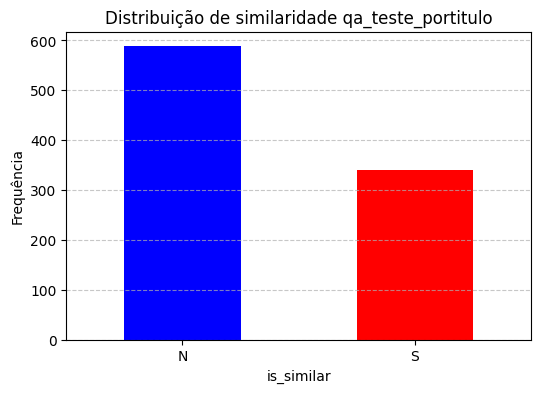

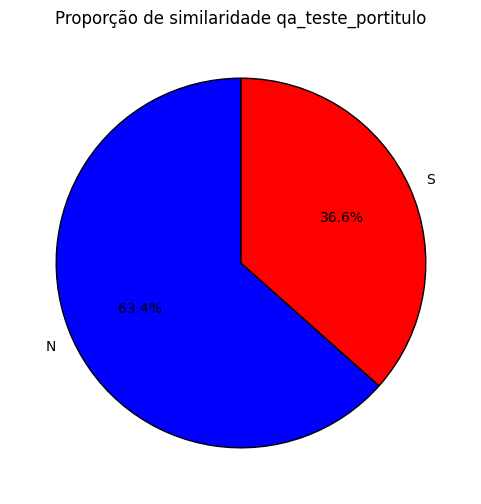

In [ ]:
import matplotlib.pyplot as plt

cores = ["blue", "red", "green", "purple", "orange", "brown", "pink", "gray", "cyan", "magenta"]

# Criando um gráfico de barras
plt.figure(figsize=(6, 4))
obtendo_respostas["is_similar"].value_counts().plot(kind="bar", color=cores)
plt.title(f'''Distribuição de similaridade {QA_avaliado}''')
plt.xlabel("o quão similar é")
plt.ylabel("Frequência")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Criando um gráfico de pizza
plt.figure(figsize=(6, 6))
obtendo_respostas["is_similar"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=cores, startangle=90, wedgeprops={"edgecolor": "black"})
plt.title(f'''Proporção de similaridade {QA_avaliado}''')
plt.ylabel("")  # Removendo label desnecessário
plt.show()